In [7]:
from skimage import img_as_float, io, transform
from skimage.metrics import peak_signal_noise_ratio, structural_similarity as ssim
from matplotlib import pyplot as plt
from scipy import ndimage as nd
import numpy as np
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma, cycle_spin, denoise_nl_means)
from skimage import img_as_ubyte, img_as_float
import cv2
import bm3d

def imadjust(image, low_in, high_in, low_out=0, high_out=255):
    # Normalize the input range
    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # Apply the intensity transformation
    image = (image - low_in) / (high_in - low_in)
    image = np.clip(image, 0, 1)

    # Scale to the output range
    image = (high_out - low_out) * image + low_out
    image = np.clip(image, low_out, high_out)

    return image.astype(np.uint8)
    
noisy_img = img_as_float(io.imread(r"D:\BTD Code-2\Noise_image\noise_image.jpg", as_gray=True))
ref_img = img_as_float(io.imread(r"D:\BTD Code-2\Clean_image\clean_image.jpg", as_gray=True))

desired_size = (200, 200)

noisy_img = transform.resize(noisy_img, desired_size, mode='reflect', anti_aliasing=True)
ref_img = transform.resize(ref_img, desired_size, mode='reflect', anti_aliasing=True)
# change

def mse(original, denoised):
    return np.mean((original - denoised) ** 2)

def mae(original, denoised):
    return np.mean(np.abs(original - denoised))

def rmse(original, denoised):
    return np.sqrt(mse(original, denoised))

noise_psnr = peak_signal_noise_ratio(ref_img, noisy_img)
noise_ssim, _ = ssim(ref_img, noisy_img, full=True, win_size=3, data_range=1.0)
noise_mse = mse(ref_img, noisy_img)
noise_mae = mae(ref_img, noisy_img)
noise_rmse = rmse(ref_img, noisy_img)

def gaussian():
    gaussian_img = nd.gaussian_filter(noisy_img, sigma=5)
    plt.imsave("images/MRI_images/Gaussian_smoothed.jpg", gaussian_img, cmap='gray')
    
    return gaussian_img

def bilateral():
    sigma_est = estimate_sigma(noisy_img, average_sigmas=True)
    denoise_bilateral_img = denoise_bilateral(noisy_img, sigma_spatial=15)
    
    return denoise_bilateral_img

def tv_denoise():
    denoise_TV = denoise_tv_chambolle(noisy_img, weight=0.3)
    
    return denoise_TV

def wavelet():
    wavelet_smoothed = denoise_wavelet(noisy_img,
                                   method='BayesShrink', 
                                   mode='soft',
                                   rescale_sigma=True)
    
    return wavelet_smoothed

def shift_invariant():    
    denoise_kwargs = dict(wavelet='db1', 
                      method='BayesShrink',
                      rescale_sigma=True)

    all_psnr = []
    max_shifts = 3     #0, 1, 3, 5

    Shift_inv_wavelet = cycle_spin(noisy_img, 
                              num_workers=1,
                              func=denoise_wavelet, 
                              max_shifts = max_shifts, 
                              func_kw=denoise_kwargs)
    
    return Shift_inv_wavelet

def NLM_skimage():
    sigma_est = np.mean(estimate_sigma(noisy_img))

    NLM_skimg_denoise_img = denoise_nl_means(noisy_img, h=1.15 * sigma_est, fast_mode=True,
                                patch_size=9, patch_distance=5)
    
    return  NLM_skimg_denoise_img

def NLM_cv2():
    # Convert the image to uint8
    noisy_img_uint8 = img_as_ubyte(noisy_img)

    # Apply NLM denoising
    NLM_CV2_denoise_img = cv2.fastNlMeansDenoising(noisy_img_uint8, None, 3, 7, 21)

    # Convert back to float for saving and visualization
    NLM_CV2_denoise_img_float = img_as_float(NLM_CV2_denoise_img)
    
    return NLM_CV2_denoise_img_float

def BM3D_denoising(stage_arg_val):
    if stage_arg_val == "all_stages":
        BM3D_denoised_image = bm3d.bm3d(noisy_img, sigma_psd=0.2, stage_arg=bm3d.BM3DStages.ALL_STAGES)
    else:
        BM3D_denoised_image = bm3d.bm3d(noisy_img, sigma_psd=0.2, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
    
    return BM3D_denoised_image

methods = [
    "noisy",
    "gaussian",
    "bilateral",
    "tv",
    "wavelet",
    "shift_invariant",
    "NLM_skimage",
    "NLM_cv2",
    "BM3D_allstages",
    "BM3D_hardthres",
    "NAFNET"
]

gaussian_img = gaussian()
bilateral_img = bilateral()
tv_img = tv_denoise()
wavelet_img = wavelet()
shift_invariant_img = shift_invariant()
NLM_skimage_img = NLM_skimage()
NLM_cv2_img = NLM_cv2()
BM3D_allstages_img = BM3D_denoising("all_stages")
BM3D_hardthres_img = BM3D_denoising("hardthres")

denoised_images = {
    "gaussian": gaussian_img,
    "bilateral": bilateral_img,
    "tv": tv_img,
    "wavelet": wavelet_img,
    "shift_invariant": shift_invariant_img,
    "NLM_skimage": NLM_skimage_img,
    "NLM_cv2": NLM_cv2_img,
    "BM3D_allstages": BM3D_allstages_img,
    "BM3D_hardthres": BM3D_hardthres_img
}
    
psnr_vals = [noise_psnr]
ssim_vals = [noise_ssim]
mse_vals = [noise_mse]
mae_vals = [noise_mae]
rmse_vals = [noise_rmse]

for img in denoised_images:
    cleaned_psnr = peak_signal_noise_ratio(ref_img, denoised_images[img])
    cleaned_ssim, _ = ssim(ref_img, denoised_images[img], full=True, win_size=3, data_range=1.0)
    mse_val = mse(ref_img, denoised_images[img])
    mae_val = mae(ref_img, denoised_images[img])
    rmse_val = rmse(ref_img, denoised_images[img])
    
    psnr_vals.append(cleaned_psnr)
    ssim_vals.append(cleaned_ssim)
    mse_vals.append(mse_val)
    mae_vals.append(mae_val)
    rmse_vals.append(rmse_val)
    
    plt.imsave(f"images/MRI_images/{img}_denoised.jpg", denoised_images[img], cmap='gray')

NAFNET_denoised_img = io.imread(r"D:\BTD Code-2\Enhanced_image\enhanced_image_imadjust.jpg", as_gray=True)
NAFNET_denoised_img = transform.resize(NAFNET_denoised_img, desired_size, mode='reflect', anti_aliasing=True)

psnr_den = peak_signal_noise_ratio(ref_img, NAFNET_denoised_img)
ssim_den = ssim(ref_img, NAFNET_denoised_img, win_size=3, data_range=1.0)
mse_den = mse(ref_img, NAFNET_denoised_img)
mae_den = mae(ref_img, NAFNET_denoised_img)
rmse_den = rmse(ref_img, NAFNET_denoised_img)

psnr_vals.append(psnr_den)
ssim_vals.append(ssim_den)
mse_vals.append(mse_den)
mae_vals.append(mae_den)
rmse_vals.append(rmse_den)

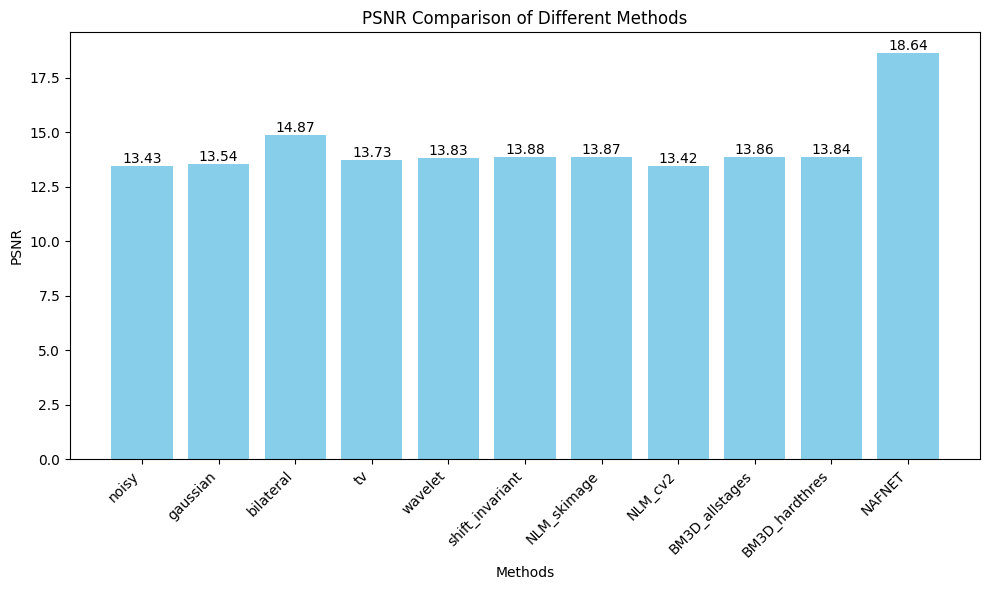

In [2]:
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, psnr_vals, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2), ha='center', va='bottom')

plt.xlabel('Methods')
plt.ylabel('PSNR')
plt.title('PSNR Comparison of Different Methods')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

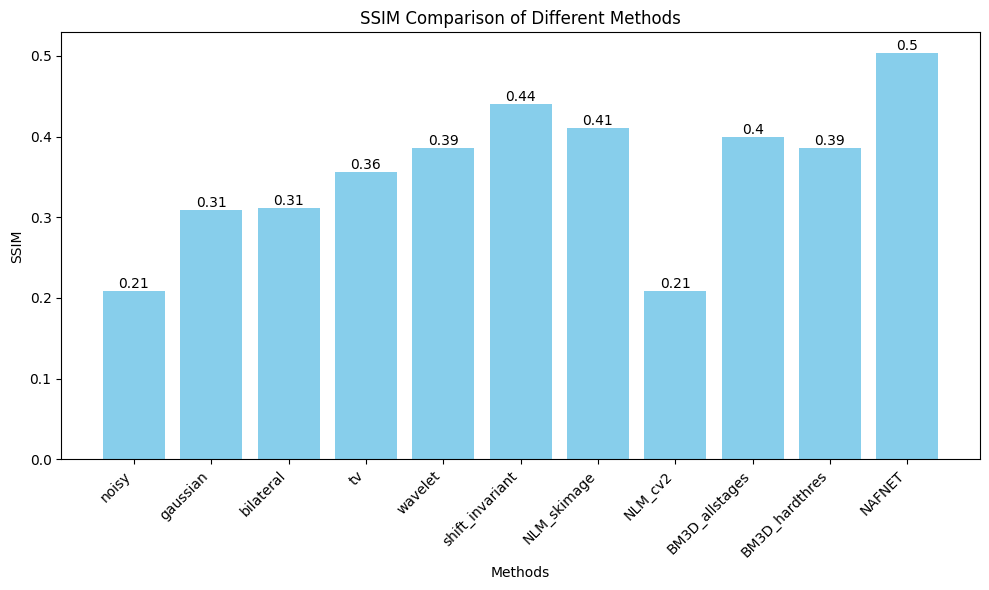

In [3]:
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, ssim_vals, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2), ha='center', va='bottom')

plt.xlabel('Methods')
plt.ylabel('SSIM')
plt.title('SSIM Comparison of Different Methods')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

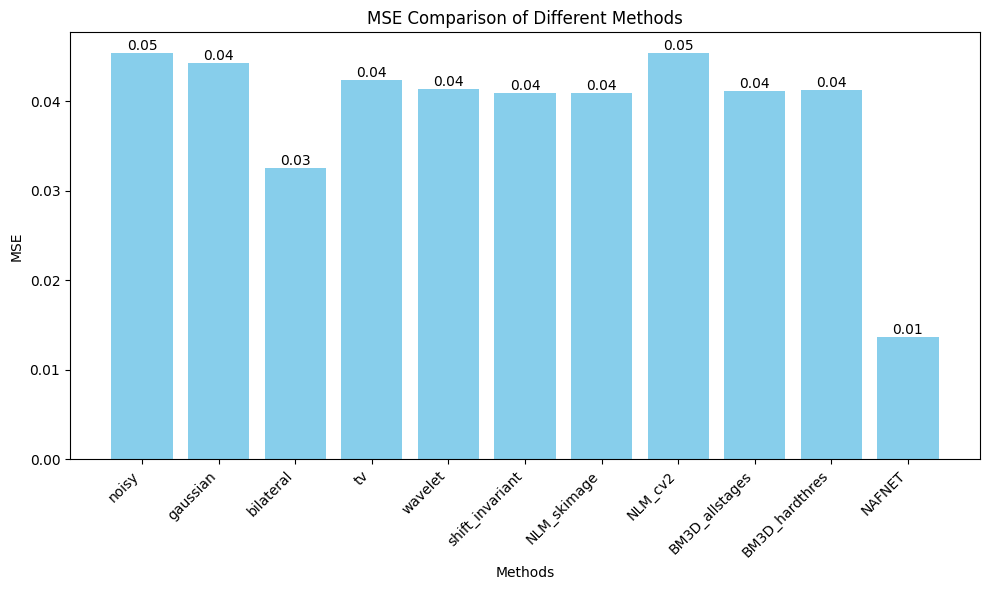

In [4]:
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, mse_vals, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2), ha='center', va='bottom')

plt.xlabel('Methods')
plt.ylabel('MSE')
plt.title('MSE Comparison of Different Methods')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

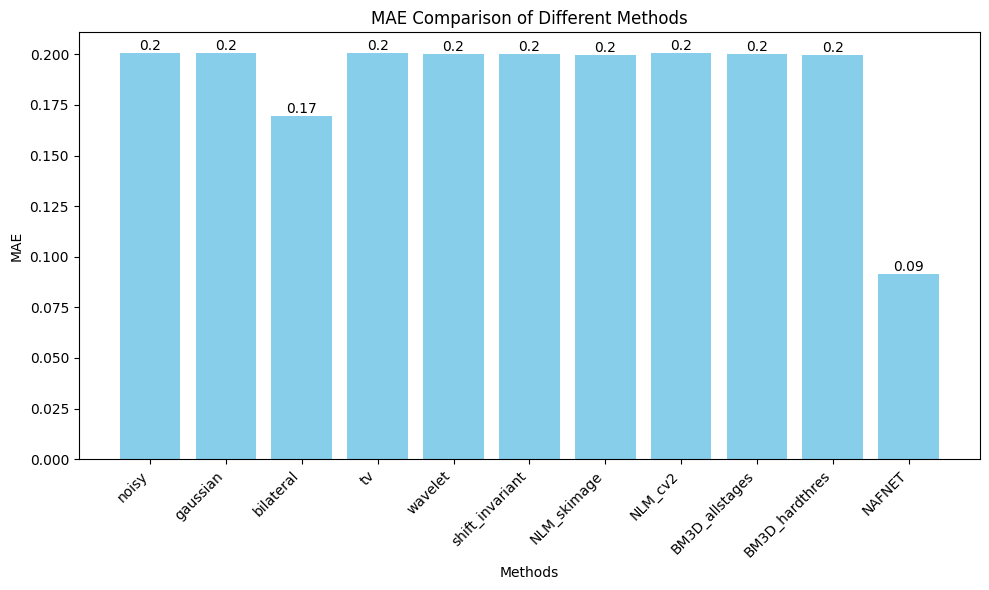

In [5]:
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, mae_vals, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2), ha='center', va='bottom')

plt.xlabel('Methods')
plt.ylabel('MAE')
plt.title('MAE Comparison of Different Methods')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

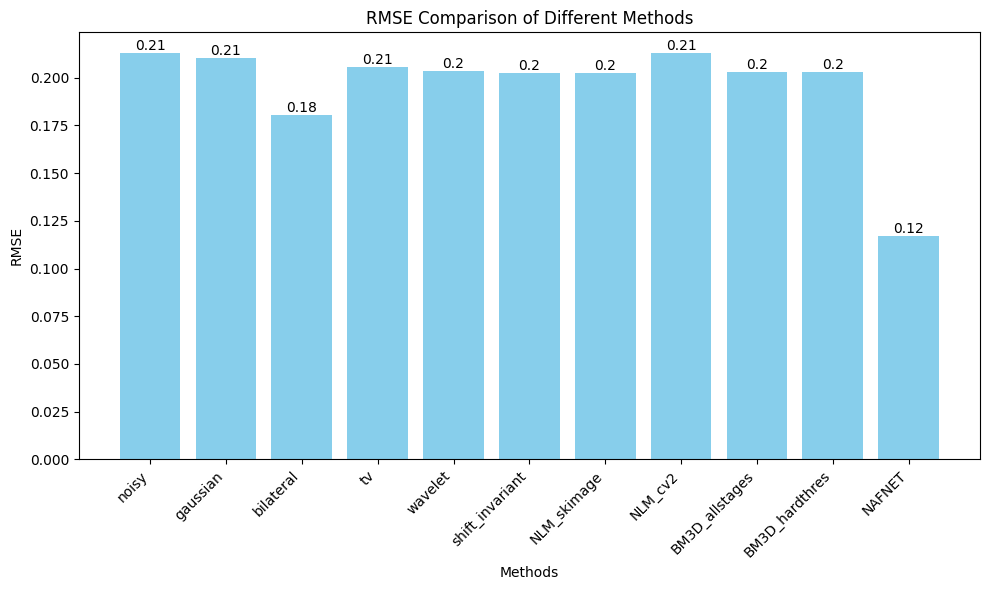

In [6]:
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, rmse_vals, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2), ha='center', va='bottom')

plt.xlabel('Methods')
plt.ylabel('RMSE')
plt.title('RMSE Comparison of Different Methods')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()